In [1]:
# Importing necessary library
from messytables import CSVTableSet, type_guess, \
  types_processor, headers_guess, headers_processor, \
  offset_processor
  
import pandas as pd
import numpy as np
from IPython.display import display
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [2]:
# Open the Sales Activity Report into Python
fh = open('sales_activity_report.csv', 'rb')

# Load a file object:
table_set = CSVTableSet(fh)

# If you aren't sure what kind of file it is, you can use
# any_tableset.
#table_set = any_tableset(fh)

# A table set is a collection of tables:
row_set = table_set.tables[0]

# guess header names and the offset of the header:
offset, headers = headers_guess(row_set.sample)
row_set.register_processor(headers_processor(headers))

# add one to begin with content, not the header:
row_set.register_processor(offset_processor(offset + 1))

# guess column types:
types = type_guess(row_set.sample, strict=True)

# and tell the row set to apply these types to
# each row when traversing the iterator:
row_set.register_processor(types_processor(types))

In [3]:
# import the table of values from the summary report
df = pd.read_csv('sales_activity_report.csv', header = offset-1, skipfooter=2, engine='python')
em = pd.read_csv('emojis.csv')

# Remove the dollar sign from Order Price, Seller Shipping Discount,
# Upgraded Shipping Label Fee, Net Earnings, Sales Tax (Paid by Buyer)
df['Order Price']=[x.strip('$') for x in df['Order Price']]
df['Order Price']=df['Order Price'].astype(float)

df['Seller Shipping Discount']=[x.strip('$') for x in df['Seller Shipping Discount']]
df['Seller Shipping Discount']=df['Seller Shipping Discount'].astype(float)

df['Upgraded Shipping Label Fee']=[x.strip('$') for x in df['Upgraded Shipping Label Fee']]
df['Upgraded Shipping Label Fee']=df['Upgraded Shipping Label Fee'].astype(float)

df['Net Earnings']=[x.strip('$') for x in df['Net Earnings']]
df['Net Earnings']=df['Net Earnings'].astype(float)

#df['Sales Tax (Paid by Buyer)']=[x.strip('$') for x in df['Sales Tax (Paid by Buyer)']]
df['Sales Tax (Paid by Buyer)']=df['Sales Tax (Paid by Buyer)'].astype(str).str.replace('$', '')
df['Sales Tax (Paid by Buyer)']=df['Sales Tax (Paid by Buyer)'].replace(
    [r'--$', 'nan'], value=np.nan, regex=True)
df['Sales Tax (Paid by Buyer)']=df['Sales Tax (Paid by Buyer)'].astype(float)

# Convert Listing Date and Order Date into datetime format
df['Listing Date'] = pd.to_datetime(df['Listing Date'])
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [4]:
# Remove emoji from listing title
char_list = em['emoji'].values.tolist()
def remove_emoji(listing_title):
    return re.sub("|".join(char_list), "", listing_title)

Listing_titles = pd.Series(df['Listing Title'].apply(remove_emoji))
# Appling word tokenize in the listing titles for breaking the titles
token_titles = Listing_titles.apply(word_tokenize)

# Finding the frequency distinct throughout all the titles
token_titles_combined = [st for row in token_titles for st in row]
fdist = FreqDist(token_titles_combined)

# To find the frequency of top 26 words
fdist10 = fdist.most_common(26) # Key tags include NWT, JUST, !, IN, HP, LEFT

# Proportion of listing titles that contain key tags
Listing_titles_key_tags = Listing_titles.str.contains('NWT|JUST|!|IN|HP|LEFT', case = True)
prop = np.sum(Listing_titles_key_tags) / Listing_titles.shape[0]
print('Proportion of Listing titles that contain key tags: %.2f' % (prop*100)); del(prop)

Proportion of Listing titles that contain key tags: 85.70


In [5]:
# Create variable that represents the number of days it took to sell
time_to_sell = df['Order Date'] - df['Listing Date']
time_to_sell.rename('Time to Sell', inplace=True)

# Create variable that represents the net earnings per day
net_earnings_per_day = df['Net Earnings'] / time_to_sell.replace(pd.Timedelta('0 days'), pd.Timedelta('1 days')).astype('timedelta64[D]')
net_earnings_per_day = round(net_earnings_per_day, 2)
net_earnings_per_day = net_earnings_per_day.rename('Net Earnings per day', inplace=True)

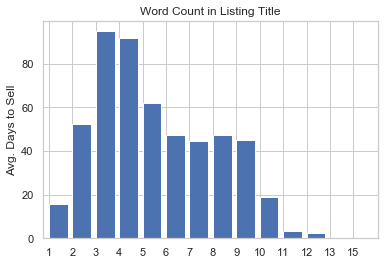

In [6]:
# Word count versus the time it took to sell
foo = pd.concat([token_titles.apply(len), time_to_sell.astype('timedelta64[D]')], axis=1)
foo.rename(columns={'Listing Title':'Word count'}, inplace=True)
# Average time to sell based on word count
sns.set(style="whitegrid")
chart = foo.groupby('Word count').mean().plot(
        kind='bar', align='edge', width=0.8)
plt.title('Word Count in Listing Title')
plt.ylabel('Avg. Days to Sell', fontsize=12)
plt.xlabel('', fontsize=12)
plt.legend().remove()
chart.set_xticklabels(chart.get_xticklabels(), rotation=0)
plt.show(); del(chart, foo)

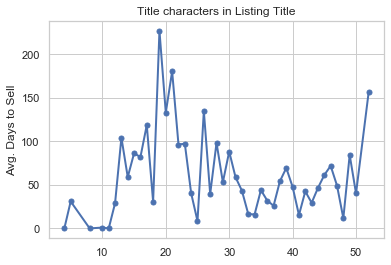

In [7]:
# Title characters versus the time it took to sell
foo = pd.concat([Listing_titles.apply(len), time_to_sell.astype('timedelta64[D]')], axis=1)
foo.rename(columns={'Listing Title':'Title characters'}, inplace=True)
# Average time to sell based on title characters
foo = foo.groupby('Title characters').mean()
sns.set(style="whitegrid")
chart = plt.plot(foo.index, foo.values, 'b-o', linewidth=2, markersize=5)
plt.title('Title characters in Listing Title')
plt.ylabel('Avg. Days to Sell', fontsize=12)
plt.xlabel('', fontsize=12)
plt.show(); del(chart, foo)

In [8]:
# Find the top brands that sell the quickest

# Create data frame that contains the time it took to sell and brands
df1 = pd.concat([df['Brand'], time_to_sell.astype('timedelta64[D]'), net_earnings_per_day], axis=1)
# Average the net earnings
df1 = df1.groupby('Brand').mean()
df1.rename(columns={'Net Earnings per day':'Avg Net Earnings per day', 
                   'Time to Sell':'Avg Days to Sell'}, inplace=True)

In [9]:
# Top brands with the best (avg) net earnings
q = df1.sort_values(by=['Avg Days to Sell', 'Avg Net Earnings per day'], ascending=[True, False])
top_avg_net_earnings = q.nlargest(7, 'Avg Net Earnings per day')
display(round(top_avg_net_earnings, 2))

,Avg Days to Sell,Avg Net Earnings per day
Brand,,
Gucci,7.0,45.71
UGG,2.0,28.00
BCBGeneration,0.0,27.38
Sole (Sense)ability,0.0,25.60
Catherine Malandrino,0.0,24.00
Ted Baker,2.0,24.00
Sam Edelman,40.0,22.65


In [10]:
# Top brands with the quickest sells
quickest_sells = q.nsmallest(7, 'Avg Days to Sell')
display(round(quickest_sells, 2))
del(df1, q)

,Avg Days to Sell,Avg Net Earnings per day
Brand,,
BCBGeneration,0.0,27.38
Sole (Sense)ability,0.0,25.60
Catherine Malandrino,0.0,24.00
Dexflex Comfort,0.0,14.80
American Apparel,0.0,14.40
Liberty,0.0,8.00
Calvin Klein,0.0,5.05


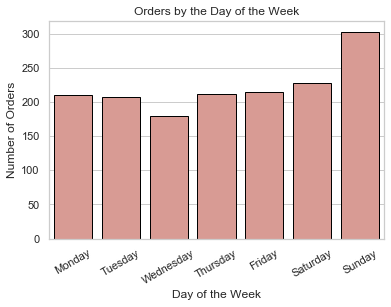

In [11]:
# Find the best selling day of the week

# Group number of items sold and day of week
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_by_weekday = pd.Categorical(df['Order Date'].dt.day_name(), categories=cats, ordered=True)
orders_by_weekday_count = orders_by_weekday.value_counts()
sns.set(style="whitegrid")
chart = sns.barplot(orders_by_weekday_count.index, orders_by_weekday_count.values,
                    color="salmon", saturation=.5,
                    edgecolor='black')
plt.title('Orders by the Day of the Week')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, cats)

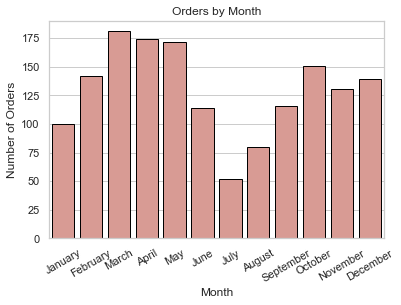

In [12]:
# Find the best selling day of the month

# Group number of items sold and month

cats = ['January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December']
orders_by_month = pd.Categorical(df['Order Date'].dt.month_name(), categories=cats, ordered=True)
orders_by_month_count = orders_by_month.value_counts()
sns.set(style="whitegrid")
chart = sns.barplot(orders_by_month_count.index, orders_by_month_count.values,
                    color="salmon", saturation=.5,
                    edgecolor='black')
plt.title('Orders by Month')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Month', fontsize=12)
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, cats)

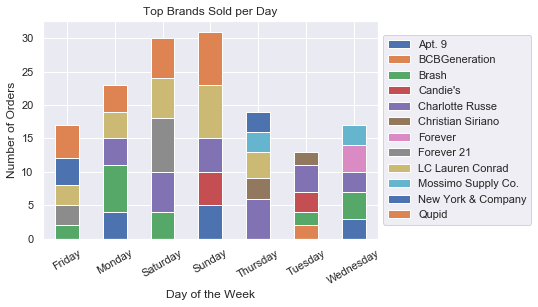

In [13]:
# Compare top selling brands per week

df2 = pd.concat([df['Brand'], df['Order Date'].dt.day_name()], axis=1)
brands_by_week = pd.DataFrame(df2.groupby(['Order Date', 'Brand']).size())
brands_by_week.rename(columns={0:'count'}, inplace=True)
g = brands_by_week['count'].groupby(level=0, group_keys=False)
brands_by_week = pd.DataFrame(g.nlargest(5)); del(df2, g)

sns.set(style="darkgrid", palette="deep")
chart = brands_by_week.unstack().plot(kind='bar', stacked=True)
plt.title('Top Brands Sold per Day')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
handles, labels = chart.get_legend_handles_labels()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=[i.strip("()").replace("count, ", "") for i in labels])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, handles, labels)

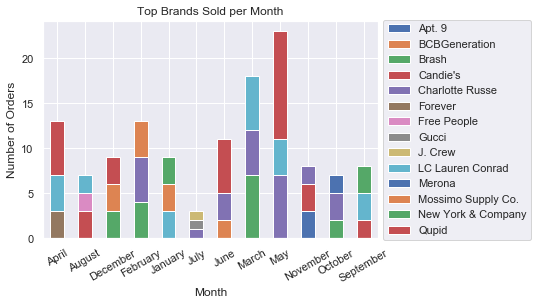

In [14]:
# Compare top selling brands per week

df3 = pd.concat([df['Brand'], df['Order Date'].dt.month_name()], axis=1)
brands_by_month = pd.DataFrame(df3.groupby(['Order Date', 'Brand']).size())
brands_by_month.rename(columns={0:'count'}, inplace=True)
g = brands_by_month['count'].groupby(level=0, group_keys=False)
brands_by_month = pd.DataFrame(g.nlargest(3)); del(df3, g)

sns.set(style="darkgrid")
chart = brands_by_month.unstack().plot(kind='bar', stacked=True)
plt.title('Top Brands Sold per Month')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Month', fontsize=12)
handles, labels = chart.get_legend_handles_labels()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=[i.strip("()").replace("count, ", "") for i in labels])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, handles, labels)

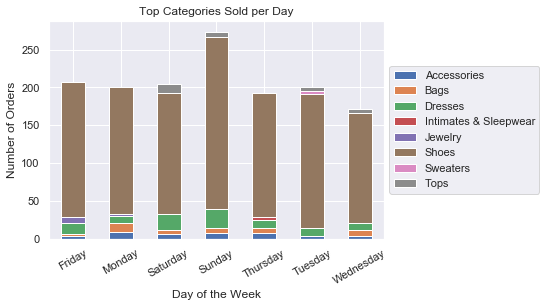

In [15]:
# Compare top categories per week

df2 = pd.concat([df['Category'], df['Order Date'].dt.day_name()], axis=1)
categories_by_week = pd.DataFrame(df2.groupby(['Order Date', 'Category']).size())
categories_by_week.rename(columns={0:'count'}, inplace=True)
g = categories_by_week['count'].groupby(level=0, group_keys=False)
categories_by_week = pd.DataFrame(g.nlargest(5)); del(g, df2)

sns.set(style="darkgrid", palette="deep")
chart = categories_by_week.unstack().plot(kind='bar', stacked=True)
plt.title('Top Categories Sold per Day')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
handles, labels = chart.get_legend_handles_labels()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=[i.strip("()").replace("count, ", "") for i in labels])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, handles, labels)

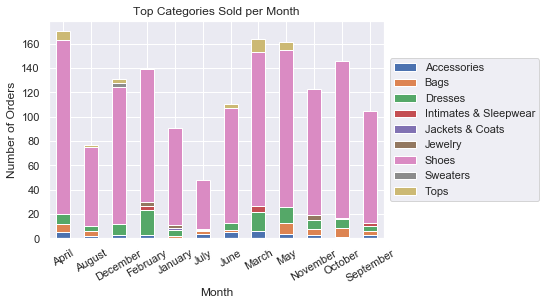

In [16]:
# Compare top categories per month

df3 = pd.concat([df['Category'], df['Order Date'].dt.month_name()], axis=1)
categories_by_month = pd.DataFrame(df3.groupby(['Order Date', 'Category']).size())
categories_by_month.rename(columns={0:'count'}, inplace=True)
g = categories_by_month['count'].groupby(level=0, group_keys=False)
categories_by_month = pd.DataFrame(g.nlargest(5)); del(df3, g)

sns.set(style="darkgrid")
chart = categories_by_month.unstack().plot(kind='bar', stacked=True)
plt.title('Top Categories Sold per Month')
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Month', fontsize=12)
handles, labels = chart.get_legend_handles_labels()
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=[i.strip("()").replace("count, ", "") for i in labels])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
plt.show(); del(chart, handles, labels)

In [17]:
# Building a logistic regression model

# Create training and test sets
X = df[['Brand','Order Price', 'Buyer State', 'Offer Order']].dropna()
y = X[['Offer Order']]
X = X[['Brand','Order Price', 'Buyer State']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.4,
                                                    random_state=42)
# prepare input data
def prepare_inputs(X_train, X_test):
	oe = OneHotEncoder(handle_unknown='ignore')
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train.values.ravel())
	y_train_enc = le.transform(y_train.values.ravel())
	y_test_enc = le.transform(y_test.values.ravel())
	return y_train_enc, y_test_enc

# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [18]:
# summarize
display('Train', X_train.shape, y_train.shape)
display('Test', X_test.shape, y_test.shape)

'Train'

(256, 3)

(256, 1)

'Test'

(172, 3)

(172, 1)

In [19]:
# Create the classifier: logreg
logreg = LogisticRegression(solver='lbfgs')

# Fit the classifier to the training data
logreg.fit(X_train_enc, y_train_enc)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test_enc)

In [20]:
# Compute and print the confusion matrix
print(confusion_matrix(y_test_enc, y_pred))

[[  1  30]
 [  3 138]]


In [21]:
# Compute and print the classification report
print(classification_report(y_test_enc, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.03      0.06        31
           1       0.82      0.98      0.89       141

    accuracy                           0.81       172
   macro avg       0.54      0.51      0.48       172
weighted avg       0.72      0.81      0.74       172



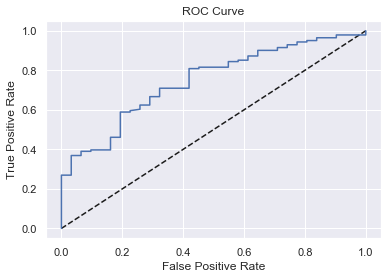

In [22]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_enc)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [23]:
# Evaluate predictions
accuracy = accuracy_score(y_test_enc, y_pred)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 80.81
